In [1]:
from __future__ import annotations
import math
from collections.abc import Iterable, Callable

In [2]:
# set graphviz
import os
os.environ['PATH'] = r'C:\Program Files\Graphviz\bin'

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges= set(), set()
    
    def build(v):
        if v  in nodes:
            return
        
        nodes.add(v)
        for child in v.prev:
            edges.add((child, v))
            build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges= trace(root)
    
    for node in nodes:
        uid = str(id(node))
        
        dot.node(name=uid, label=f'{node.label} | data: {node.data:.4f} | grad: {node.grad:.4f}',shape='record')
        
        if node.op:
            dot.node(name = uid+node.op, label=node.op)
            
            dot.edge(uid+node.op, uid)
        
    for n1, n2 in edges:
        _n1 = str(id(n1))
        _n2 = str(id(n2))+n2.op
        
        dot.edge(_n1, _n2)
    
    return dot
                
                

In [4]:
class Neuron:
    """
    what does single neuron contains
    """

    def __init__(self, data, _children: Iterable | None = None, op='', label='') -> None:
        self.data = data
        self._prev = set(_children) if _children else set()
        self.grad: int | float = 0
        self._op = op
        self.label = label
        # its intresting to note backward will be called by output neuron
        self._backward: Callable = lambda: None

    def __str__(self) -> str:
        return f"Label: {self.label} | Data:{self.data:.4f} | Grad:{self.grad:.4f}"

    def __add__(self, other: Neuron | int | float) -> Neuron:

        if isinstance(other, int):
            other = Neuron(other)
        elif isinstance(other, float):
            other = Neuron(other)
        elif isinstance(other, Neuron):
            pass
        data = self.data + other.data
        out = Neuron(data, _children=(self, other), op='+')

        def _backward():
            # local derivative time global derivative
            # for addition local derivative will be 1
            # global derivate will be out.grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other: Neuron | int | float) -> Neuron:
        if isinstance(other, int):
            other = Neuron(other)
        elif isinstance(other, float):
            other = Neuron(other)
        elif isinstance(other, Neuron):
            pass
        data = self.data * other.data
        out = Neuron(data, _children=(self, other), op='*')

        def _backward():
            # local derivative time global derivative
            # for multiplication local derivative will be other.data
            # global derivate will be out.grad
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        
        t = (math.exp(2*n) -1 ) / (math.exp(2*n) + 1)
        out = Neuron(t, _children=(self,), op='tanh')
        
        def _backward():
            # local derivative time global derivative
            # for tanh local derivative will be 1-tanh2(x)
            # global derivate will be out.grad
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

    @property
    def prev(self):
        """
        Getter property for protected variable _prev
        """
        return self._prev

    @property
    def op(self):
        """
        Getter for self._op
        """
        return self._op

    def backprop(self):
        """
        Backpropagate
        """
        self.grad = 1.0
        topo = []
        visited = set()

        def build_topo(node):
            if node in visited: return
            
            visited.add(node)
            for child in node.prev:
                build_topo(child)
            topo.append(node)

        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [5]:
x1 = Neuron(2.0, label='x1')
x2 = Neuron(0.0, label='x2')
w1 = Neuron(-3.0, label='w1')
w2 = Neuron(1.0, label='w2')
b = Neuron(6.8813735870195432, label='b')
x1w1 = x1 * w1
x2w2 = x2 * w2

x1w1.label = 'x1*w1'
x2w2.label = 'x2*w2'

x1w1_x2w2 = x1w1 + x2w2
x1w1_x2w2.label = 'x1*w1 + x2*w2'

n = x1w1_x2w2 + b
n.label = 'n'
o = n.tanh() ; o.label = 'o'

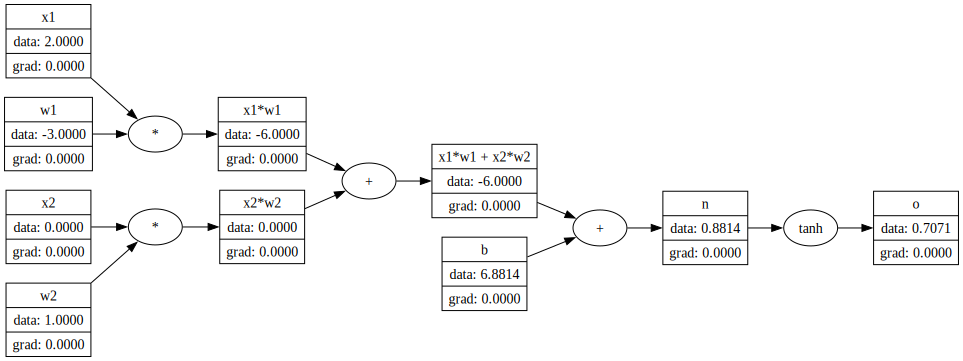

In [6]:
draw_dot(o)

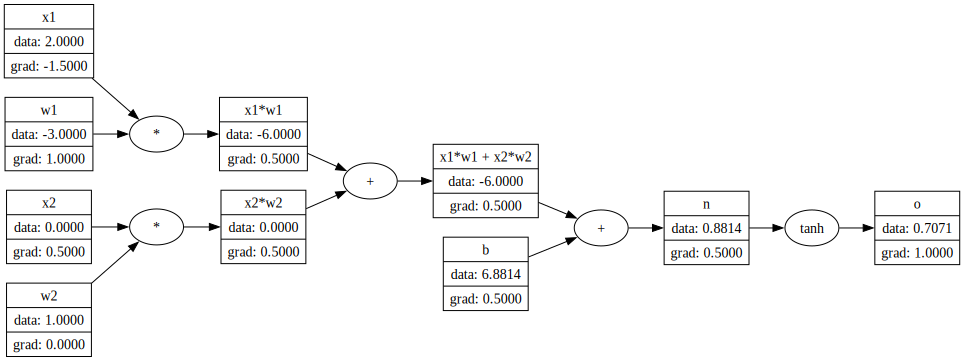

In [7]:
o.backprop()
draw_dot(o)